## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch 
from torch import nn 

torch.__version__

'1.12.1+cu102'

In [2]:
# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one... ")
    image_path.mkdir(parents=True, exist_ok=True)

    # download file
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data....")
        f.write(request.content)


    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating one... 
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Random image path: data/pizza_steak_sushi/train/pizza/2330965.jpg
Image class: pizza
Image height: 512
Image class: 512


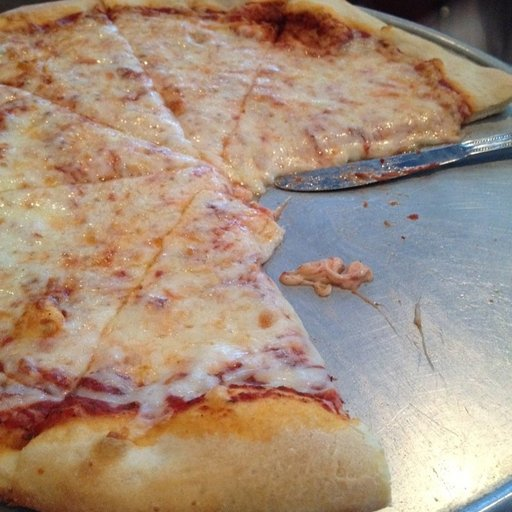

In [7]:
import random
from PIL import Image

# set seed
random.seed(42)

# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# get random path
random_image_path = random.choice(image_path_list)

# get image clas from path name
image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image class: {img.width}")

img

(-0.5, 511.5, 511.5, -0.5)

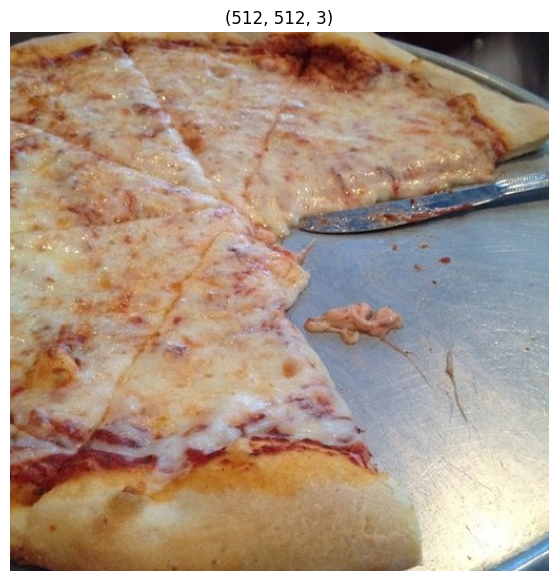

In [8]:
# using imshow() of matplotlib

import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image 
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"{img_as_array.shape}")
plt.axis(False)

## 3. Transforming data 

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# tranformer
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5), # p: probability of flip
    transforms.ToTensor() # also convert all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


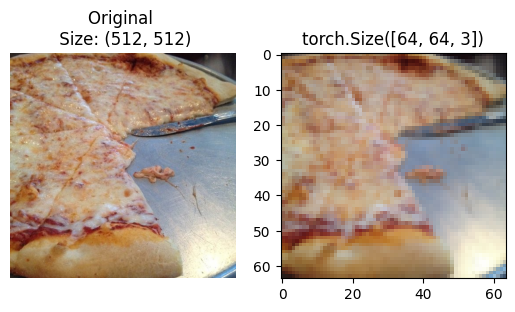

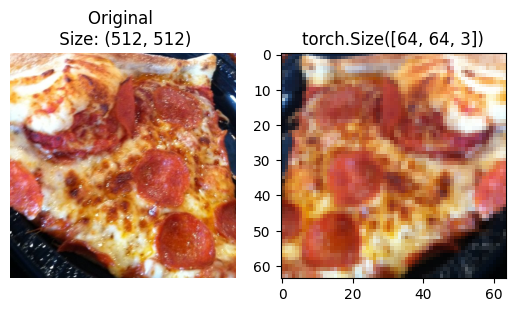

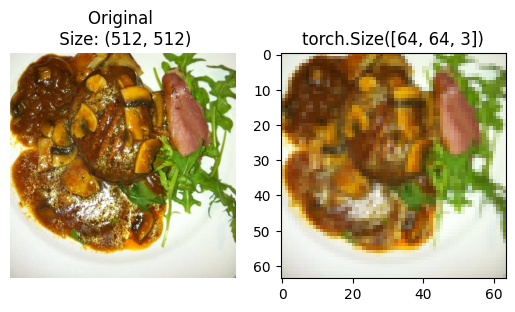

In [11]:
def plot_transformed_images(image_paths, transforms, n = 3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size: {f.size}")
            ax[0].axis("off")

            # transform and plot image
              # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transforms(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"{transformed_image.shape}")

plot_transformed_images(image_path_list, transforms=data_transform, n=3)

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)


In [12]:
# use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,  # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

len(train_data), len(test_data)

(225, 75)

In [13]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [15]:
# get class names as a list
class_names = train_data.classes
# class_names

In [16]:
# get class names as a dict
class_dict = train_data.class_to_idx
# class_dict

In [17]:
# check the lengths
len(train_data), len(test_data)

(225, 75)

In [18]:
img, label = train_data[0][0], train_data[0][1]
img.shape, img.dtype, type(label)

(torch.Size([3, 64, 64]), torch.float32, int)

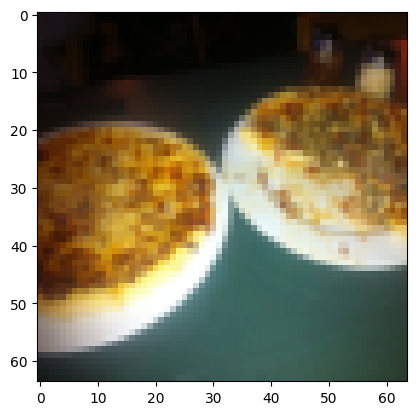

In [19]:
# plot image
plt.imshow(img.permute(1,2,0))

### 4.1 Turn loaded images into `DataLoader`'s

In [20]:
import os 
os.cpu_count()

12

In [21]:
# turn train and test datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                                # num_workers=os.cpu_count(),
                                shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usualyy need to shuffle testing data

In [22]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [23]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# instance of torchvion.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [25]:
# setup path for target directory
target_directory = train_dir
target_directory

PosixPath('data/pizza_steak_sushi/train')

In [26]:
list(os.scandir(image_path/"train"))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [27]:
# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
class_names_found

['pizza', 'steak', 'sushi']

### 5.1 Creating a helper function to get class names

In [28]:
# a function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    # get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # raise en error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    # create a dic of index labels 
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    return classes, class_to_idx

In [29]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [30]:
# to build one to replicate the functionality of `torchvision.datasets.ImageFolder()`
# write a custom dataset class (inherits from torch.utils.data.Dataset)

class CustomizedImageFolder(Dataset):

    def __init__(self, target_dir: str, transform=None) -> None:

        # get all image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))

        # setup transforms
        self.transform = transform

        # create classes and class_to_idx atributes
        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
        
    def __len__(self)-> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # data, label (X,y)
        else:
            return img, class_idx # data, label (X,y)

In [31]:
# augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [32]:
train_data_custom = CustomizedImageFolder(target_dir=train_dir, transform=train_transforms)

test_data_custom = CustomizedImageFolder(target_dir=test_dir, transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.CustomizedImageFolder at 0x7fc78502e3d0>,
 <__main__.CustomizedImageFolder at 0x7fc78502ec10>)

In [33]:
train_data_custom.classes 

['pizza', 'steak', 'sushi']

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
len(test_data_custom) == len(test_data)

True

In [36]:
len(train_data_custom) == len(train_data)

True

### 5.3 Create a function to display random images

In [37]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool=True,
                          seed: int=None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k = n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust image tensor shape for plotting
        # [c, h, w] -> [h, w, c]
        targ_image_adjust = targ_image.permute(1,2,0)

        # plot adjusted samples
        plt.subplot(1,n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


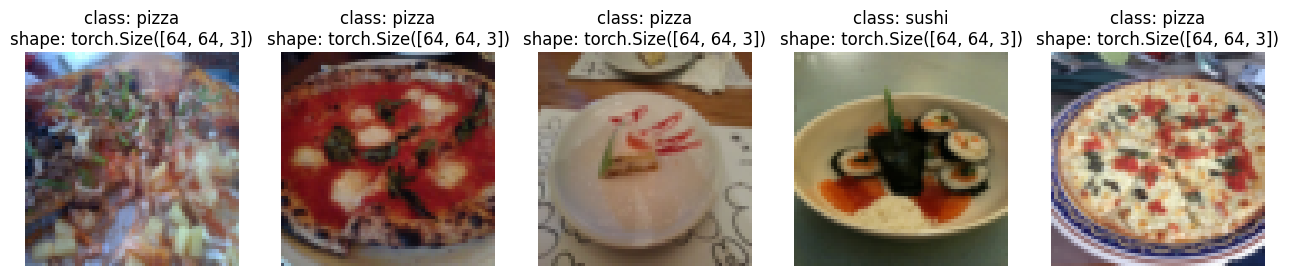

In [38]:
# display random images from ImageFolder created Dataset
display_random_images(train_data, n=5, classes=class_names, seed=None)

For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display


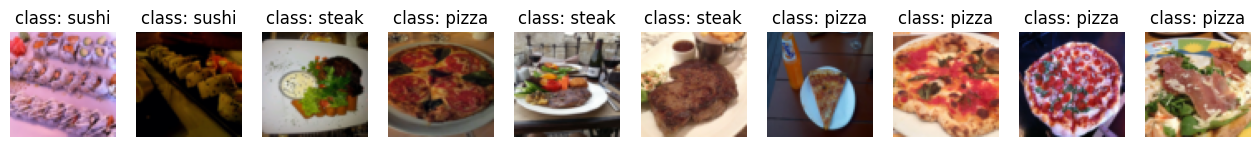

In [39]:
# display random images from CustomizedImageFolder dataset
display_random_images(train_data_custom, n=12, classes=class_names, seed=None)

For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display


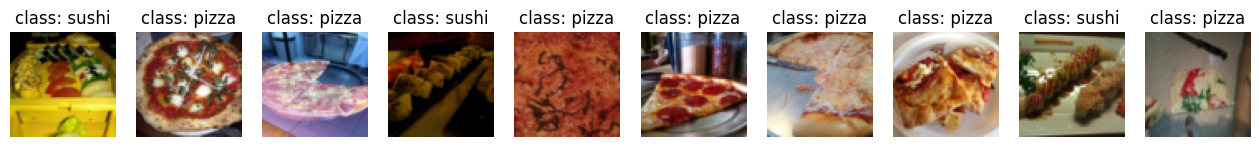

In [40]:
# display random images from CustomizedImageFolder dataset
display_random_images(train_data_custom, n=12, classes=class_names, seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s 

In [41]:
# turn train and test custom Dataset's into DataLoader's
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fc81c9bd250>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc81c9bd9a0>)

In [42]:
# get image and label from a customized DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

#### 6. Other forms of transforms (data augmentation)

In [43]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # an intensity from 0 - 31
    transforms.ToTensor() # to convert Tensor's values between 0 and 1
])

# no need to perform augumentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [46]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/pizza_steak_sushi/train/pizza/2924941.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1654444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2821048.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/29417.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/765799.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1412034.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/393658.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2785084.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/764429.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2493954.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885050.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2569760.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/618348.jpg'),
 PosixPath('dat

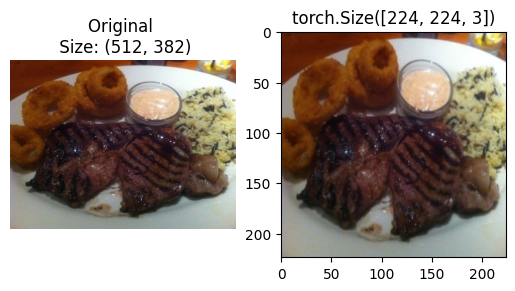

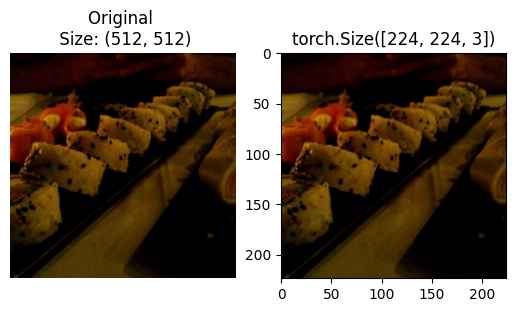

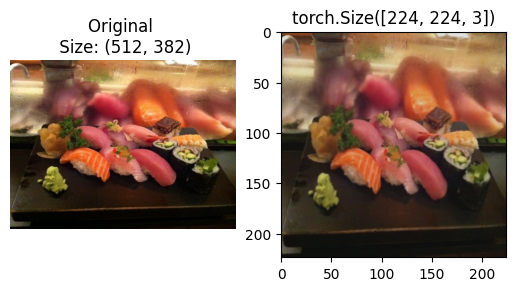

In [47]:
# plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transforms=train_transforms, 
    n = 3,
    seed=None
)

#### 7. Model 0: TinyVGG without data augmentation

In [48]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [51]:
# load and tranform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn data into dataloader
import os 
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUMBER_WORKERS = os.cpu_count()

print(f"Crrating DataLoader's with batch size {BATCH_SIZE} and {NUMBER_WORKERS} workers")

# create DataLoader's 
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUMBER_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUMBER_WORKERS)

train_dataloader_simple, test_dataloader_simple


Crrating DataLoader's with batch size 32 and 12 workers


(<torch.utils.data.dataloader.DataLoader at 0x7fc785068880>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc7850b7ee0>)

#### 7.2 Create TinyVGG model class

In [56]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels= hidden_units, kernel_size=3, stride=1, padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # default stride value is same as kernel_size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):

        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
> 
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.



**`Should do this way`**
```python 
  def forward(self, x: torch.Tensor):
        # <- leverage the benefits of operator fusion
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) 
```

**`Shouldn't do this way`**
```python
  def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
```

In [57]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,  # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))

# send to device
model_0.to(device)

model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image (to test the model)


In [58]:
# get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# get a single image from the batch and unsqueeze the image so its shape its the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]

img_single.shape, label_single.shape

(torch.Size([1, 3, 64, 64]), torch.Size([]))

In [59]:
# perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    y_logit = model_0(img_single.to(device))

In [60]:
# y_logits
y_logit

tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

In [62]:
# y_probabilities 
y_probabilites = torch.softmax(y_logit, dim=1)
y_probabilites

tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

In [64]:
# y_pred_label
y_pred_label = torch.argmax(y_probabilites, dim=1)
y_pred_label

tensor([1], device='cuda:0')

In [68]:
# display img_batch[0]
img_batch[0].shape

torch.Size([3, 64, 64])

In [73]:
# change the dimensions order to display in matplotlib
img_batch[0].permute(2,1,0).shape

torch.Size([64, 64, 3])

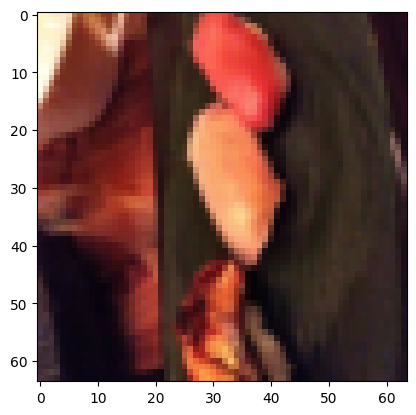

In [74]:
plt.imshow(img_batch[0].permute(2,1,0))

In [65]:
# check the label
class_names[y_pred_label]

'steak'

#### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [81]:
# install torchinfo if it's not available
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [82]:
# summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [83]:
# summary(model_0, input_size=[64, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [64, 3]                   --
├─Sequential: 1-1                        [64, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 10, 64, 64]          280
│    └─ReLU: 2-2                         [64, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [64, 10, 64, 64]          910
│    └─ReLU: 2-4                         [64, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [64, 10, 32, 32]          --
├─Sequential: 1-2                        [64, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 10, 32, 32]          910
│    └─ReLU: 2-7                         [64, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [64, 10, 32, 32]          910
│    └─ReLU: 2-9                         [64, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [64, 10, 16, 16]          --
├─Sequentia

#### 7.5 Create train & test loop functions 

In [102]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    
    # put model in train mode
    model.train()

    # train loss and train accuracy
    train_loss, train_acc = 0, 0

    # loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):

        # send data to target device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_logits = model(X)

        # calculate and accumulate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # reset gradients
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # update params
        optimizer.step()

        # calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_logits)
    
    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [103]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [93]:
try: 
    from tqdm.auto import tqdm
except: 
    !pip install tqdm
    from tqdm.auto import tqdm

In [104]:
# take in various parameters required for training and testing steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # print out what's happening
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
        )

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # return the filled results at the end of the epochs
    return results

#### 7.7 Train and Evaluate Model 0

In [105]:
len(train_data.classes)

3

In [106]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 5

# recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:04,  1.23s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604 | 


 40%|████      | 2/5 [00:02<00:03,  1.24s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979 | 


 60%|██████    | 3/5 [00:03<00:02,  1.23s/it]

Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979 | 


 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979 | 


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979 | 
Total training time:  6.156 seconds


#### 7.8 Plot the loss curves of Model 0


In [107]:
# check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [111]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # get the loss values of the results dictionary (training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # get the accuracy values of the results dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # epochs
    epochs = range(len(results["train_loss"]))

    # setup a plot
    plt.figure(figsize=(15,7))

    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

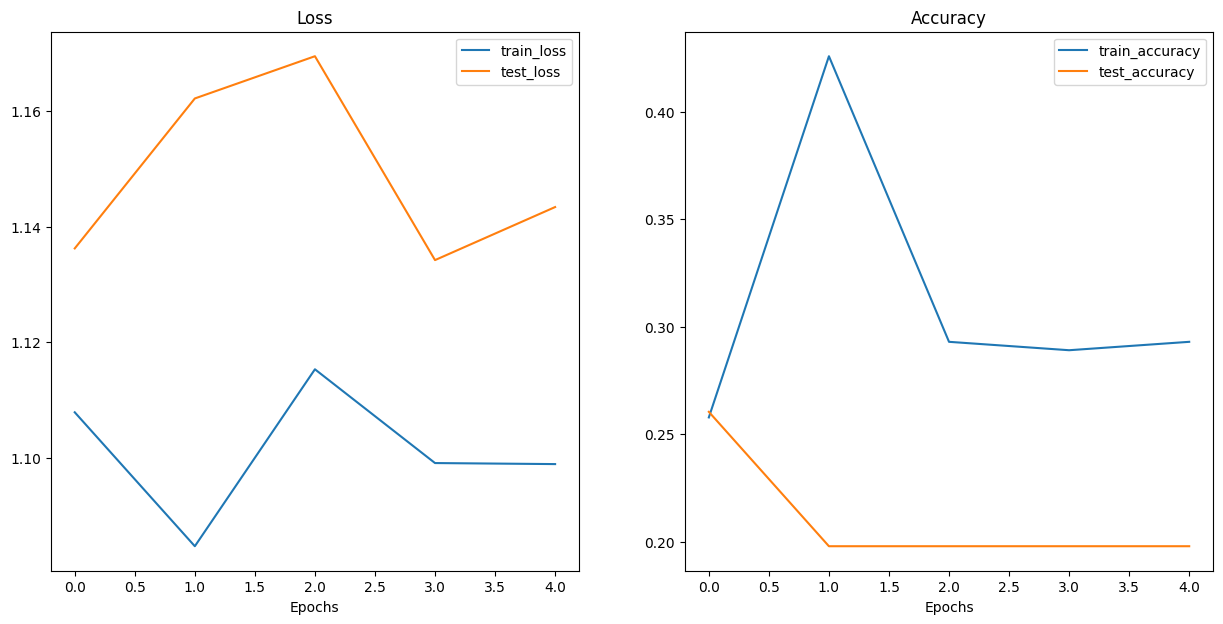

In [112]:
plot_loss_curves(model_0_results)

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

#### 8.1 How to deal with overfitting

#### 8.2 How to deal with underfitting 


#### 8.3 The balance between overfitting and underfitting

#### 9. Model 1: TinyVGG with Data Augmentation

In [113]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

#### 9.2 Create train and test `Dataset`'s and `DataLoader`'s

In [114]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [115]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc7c8a9c550>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc784f3f820>)

#### 9.3 Construct and train Model 1

In [116]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [117]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:01<00:05,  1.26s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604 | 


 40%|████      | 2/5 [00:02<00:03,  1.25s/it]

Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604 | 


 60%|██████    | 3/5 [00:03<00:02,  1.24s/it]

Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604 | 


 80%|████████  | 4/5 [00:04<00:01,  1.23s/it]

Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604 | 


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604 | 
Total training time: 6.188 seconds


#### 9.4 Plot the loss curves of Model 1

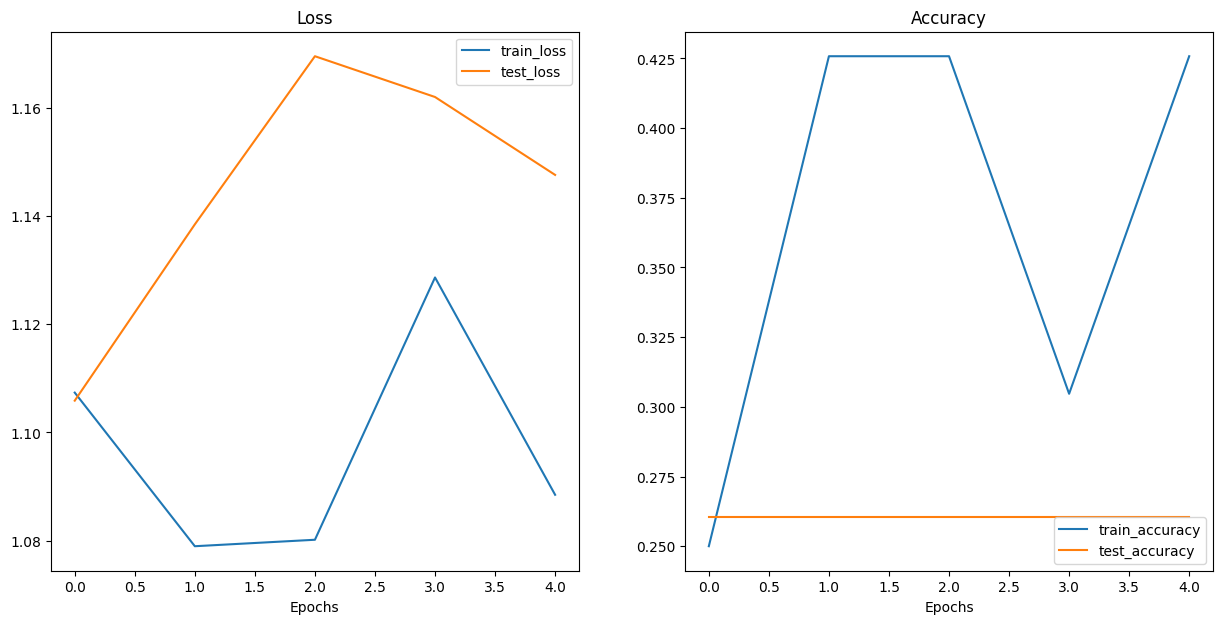

In [118]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [119]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136207,0.260417
1,1.084646,0.425781,1.162173,0.197917
2,1.115281,0.292969,1.169486,0.197917
3,1.099045,0.289062,1.134186,0.197917
4,1.098866,0.292969,1.143369,0.197917


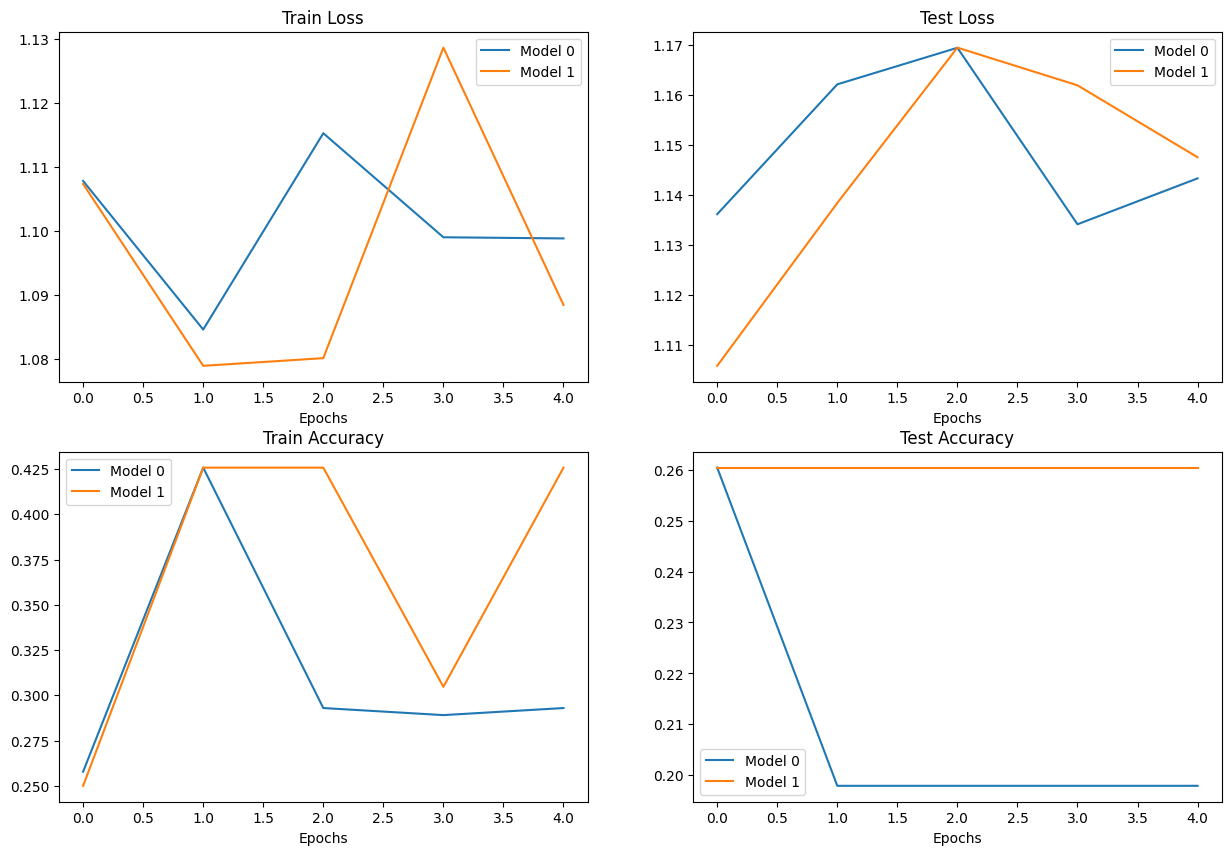

In [120]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

#### 11. Make a prediction on a custom image

In [122]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


#### 11.1 Loading in a custom image with PyTorch

In [123]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [124]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [125]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

#### 11.2 Predicting on custom images with a trained PyTorch model

(-0.5, 3023.5, 4031.5, -0.5)

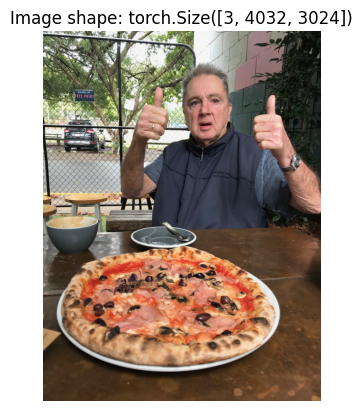

In [127]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [128]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [129]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [130]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [131]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [132]:
custom_image_pred

tensor([[ 0.1144,  0.0255, -0.1387]], device='cuda:0')

In [133]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1144,  0.0255, -0.1387]], device='cuda:0')
Prediction probabilities: tensor([[0.3716, 0.3400, 0.2885]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [134]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [135]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3716, 0.3400, 0.2885]], device='cuda:0')

#### 11.3 Putting custom image prediction together: building a function

In [137]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # make sure the model is on the target device
    model.to(device)
    
    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

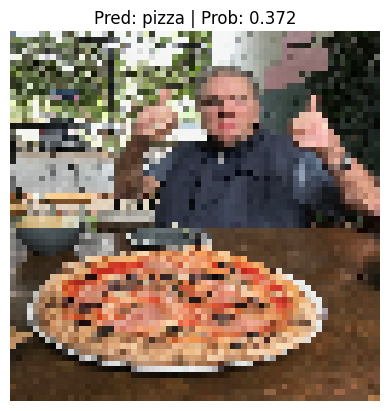

In [138]:
# pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)